In [1]:
import xgboost, textblob, string

#import data_helpers
#from DataProcessor import DataProcessor
import data_utility as du
import numpy as np

import pandas as pd 
import nltk
import seaborn as sns
import string
import warnings 
import csv
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.stem.porter import *
#from keras.preprocessing import text, sequence
from keras import preprocessing
from keras import layers, models, optimizers
from gensim.models import word2vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import mglearn
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn
%pylab
%matplotlib inline

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/christophersmyth/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


#  Detecting Sarcasm in Twitter



# Introduction

Irony and sarcasm detection is an area of Natural Language Processing that both the government and social science are interested in.  The ability to detect when the opposite of written text meant is a step toward determining intent.

# Getting Tweets

## Pulled from Twitter

In [2]:
raw_uncurated  = pd.read_csv('sarcastic_2000_201817_2320.csv')
#train.columns = ['id', 'label', 'orig']

In [3]:
raw_uncurated.head()

,id,tweets,label
0,1052699075735420928,"Well, you're only going to be allowed to play ...",1
1,1052696559811477504,@HallRaelene @Peternegus11 @MovementWa @alansa...,1
2,1052696003214827522,Friendly reminder that regardless of how many ...,1
3,1052691872840343557,@MCharlesPerry @BradenInsley @PrairieThoreau @...,1
4,1052686246273781760,@sahouraxo Come do you expect people to believ...,1


## Curated

In [4]:
raw_orig  = pd.read_csv('sarcasm_v2.csv')
#train.columns = ['id', 'label', 'orig']
labels = []
for l in raw_orig['Label']:
    if l == 'sarc':
        labels.append(1)
    else:
        labels.append(0)

raw_currated = pd.DataFrame()
raw_currated['label'] = labels
raw_currated['tweets'] = raw_orig['Response Text']

In [5]:
raw_currated.head()

,label,tweets
0,1,Therefore you accept that the Republican party...
1,1,More chattering from the peanut gallery? Haven...
2,1,"Yep, suppressing natural behavior is always th..."
3,1,"I guess we all missed your point Justine, what..."
4,1,"Evidence, I dont need no sticking evidence. Th..."


In [6]:
raw = raw_uncurated.copy()

# Baseline

In [7]:
raw[raw['label']==1]['label'].count()/raw['label'].count()

0.5

# Text Cleaning

## Remove Sarcasm Related Tags

In [8]:
no_sarcasm_tags = pd.DataFrame()
no_sarcasm_tags = raw.copy()

In [9]:
du.word_count_sarc_nonsarc_list(find_word_list=['#sarcasm','#sarcastic'],
                           text=no_sarcasm_tags['tweets'],
                          label=no_sarcasm_tags['label'])

#sarcasm
label 1 = 1004
label 0 = 0
#sarcastic
label 1 = 3
label 0 = 0


In [10]:
no_sarcasm_tags['tweets'] = du.remove_word_from_list('#sarcasm', no_sarcasm_tags['tweets'])
no_sarcasm_tags['tweets'] = du.remove_word_from_list('#sarcastic', no_sarcasm_tags['tweets'])

In [11]:
du.word_count_sarc_nonsarc_list(find_word_list=['#sarcasm','#sarcastic'],
                           text=no_sarcasm_tags['tweets'],
                          label=no_sarcasm_tags['label'])

#sarcasm
label 1 = 0
label 0 = 0
#sarcastic
label 1 = 0
label 0 = 0


## Dictionary for Object Standardization

Create a dictionary to translate acronyms and jargon from netlingo.com

In [12]:
acronyms_jargon_translate = {}
with open('acronyms_20181018_1624.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        acronyms_jargon_translate[row[0]] = row[1]

## Word Normalization, Spell Check

Ekphrasis is a text processing tool, geared towards text from social networks, such as Twitter or Facebook. Ekphrasis performs tokenization, word normalization, word segmentation (for splitting hashtags) and spell correction, using word statistics from 2 big corpora (english Wikipedia, twitter - 330mil english tweets).


ekphrasis offers the following functionality:

Social Tokenizer. A text tokenizer geared towards social networks (Facebook, Twitter...), which understands complex emoticons, emojis and other unstructured expressions like dates, times and more.

Word Segmentation. You can split a long string to its constituent words. Suitable for hashtag segmentation.

Spell Correction. You can replace a misspelled word, with the most probable candidate word.

Customization. Taylor the word-segmentation, spell-correction and term identification, to suit your needs.

Word Segmentation and Spell Correction mechanisms, operate on top of word statistics, collected from a given corpus. We provide word statistics from 2 big corpora (from Wikipedia and Twitter), but you can also generate word statistics from your own corpus. You may need to do that if you are working with domain-specific texts, like biomedical documents. For example a word describing a technique or a chemical compound may be treated as a misspelled word, using the word statistics from a general purposed corpus.

ekphrasis tokenizes the text based on a list of regular expressions. You can easily enable ekphrasis to identify new entities, by simply adding a new entry to the dictionary of regular expressions (ekphrasis/regexes/expressions.txt).

Pre-Processing Pipeline. You can combine all the above steps in an easy way, in order to prepare the text files in your dataset for some kind of analysis or for machine learning. In addition, to the aforementioned actions, you can perform text normalization, word annotation (labeling) and more.

### Expand Contractions

In [13]:
clean_tracking = pd.DataFrame()
clean_tracking['label'] = no_sarcasm_tags['label']
clean_tracking['original'] = no_sarcasm_tags['tweets']

In [14]:
clean_tracking['contractions_expanded'] = du.expand_contractions(clean_tracking['original'])

### Process Text

In [15]:
clean_tracking['text_processor'] = clean_tracking['contractions_expanded']

In [16]:
tweet_processor = du.get_tweet_processor(additional_dictionary_list=[acronyms_jargon_translate])

1
2
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [17]:
# get the processed text and un tokenize 
clean_tracking['text_processor'] = clean_tracking['text_processor'].apply(tweet_processor.pre_process_doc)
clean_tracking['text_processor'] = clean_tracking['text_processor'].apply(' '.join)

### Remove Tags from Processed Text

Except for "sarcasm" and "sarcastic", all hashtags have been expanded and will be treated as words.

Email addresses, URLs, numbers related to phone numbers, time, dates, etc. will be removed.

In [18]:
clean_tracking['tags_removed'] = du.remove_tags_from_processed_text(clean_tracking['text_processor'])

### Remove Punctuation, Numbers and Special Characters

In [19]:
clean_tracking['remove_punc_num_spch'] = clean_tracking['tags_removed'].apply(du.clean_tweet)

### Remove Stop Words

In [20]:
stop_words = stopwords.words('english')
#low_value_words = ['like', 'would', 'get', 'know']
#drop_words = stop_words + low_value_words
drop_words = stop_words

pat = r'\b(?:{})\b'.format('|'.join(drop_words))
clean_tracking['remove_stop_words'] = clean_tracking['remove_punc_num_spch'].str.replace(pat, '')
clean_tracking['remove_stop_words'] = clean_tracking['remove_stop_words'].str.replace(r'\s+', ' ')


### Lemmatization

In [21]:
clean_tracking['lemmatized'] = du.lemmatize_list(clean_tracking['remove_stop_words'])

# Analyze Data

In [158]:
# isolate data for analysis section
analysis = pd.DataFrame()
analysis['text'] = clean_tracking['lemmatized']
analysis['label'] = clean_tracking['label']
analysis['orig'] = clean_tracking['original']

## Most Common Words in Tweets

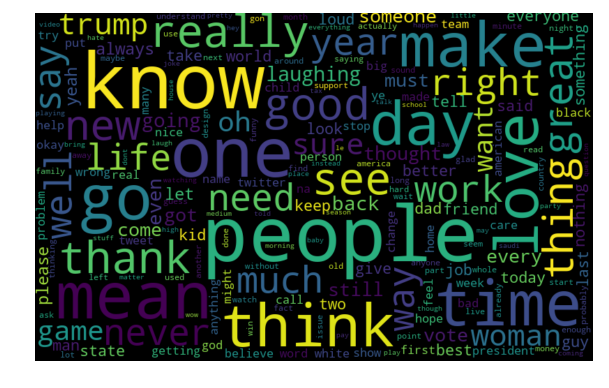

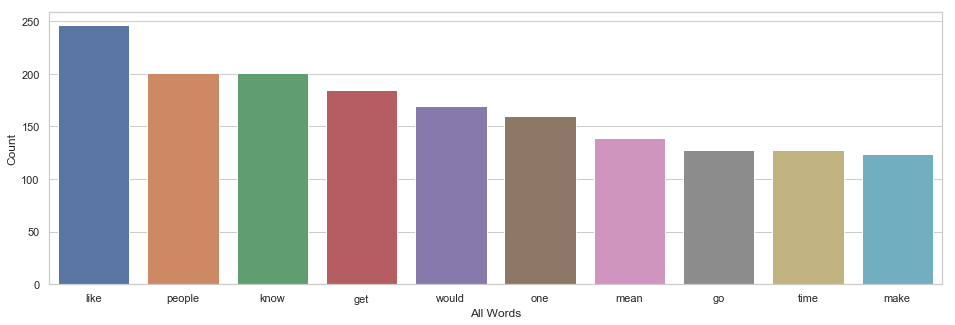

In [159]:
du.sentences_to_wordcloud(analysis['text'], drop_words)
wordcount_all = du.sentences_to_sortedwordcount(analysis['text'], drop_words)
du.wordcount_to_bar('All Words', 'Count', wordcount_all)

## Emoji Usage

In [193]:
import importlib
import data_utility as du
importlib.reload(du)

/Users/christophersmyth/sandbox/bootcamp/temp/bootcamp/cpTextClassifier/data_utility.py:450: DeprecationWarning: invalid escape sequence \w
  return ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


<module 'data_utility' from '/Users/christophersmyth/sandbox/bootcamp/temp/bootcamp/cpTextClassifier/data_utility.py'>

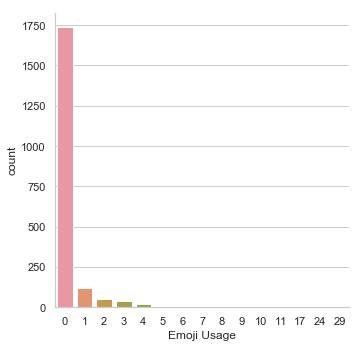

In [225]:
emoji_usage_count = du.get_emoji_usage_count(clean_tracking['original'])
du.counts_to_graph('Emoji Usage', emoji_usage_count)

In [249]:

import importlib
import data_utility as du
importlib.reload(du)

/Users/christophersmyth/sandbox/bootcamp/temp/bootcamp/cpTextClassifier/data_utility.py:450: DeprecationWarning: invalid escape sequence \w
  return ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


<module 'data_utility' from '/Users/christophersmyth/sandbox/bootcamp/temp/bootcamp/cpTextClassifier/data_utility.py'>

4


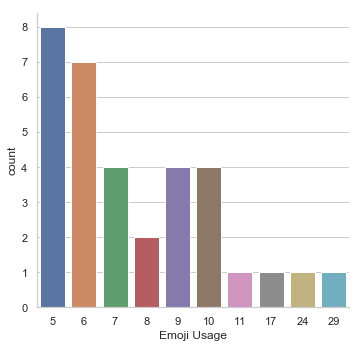

In [250]:
du.counts_to_graph_filter(4, 'Emoji Usage', emoji_usage_count)

In [235]:
du.get_tweets_based_on_count(17, raw['tweets'], emoji_usage_count).iloc[0]

"@belovedjinsoul Aww I'm very glad😳😳😳😳Thank you…！😳😳✨✨✨\nAnne is so beautiful girl…😢💕her birthday tag is happiness world...🙏🙏🙏🙏❤❤"

## Emoji Used

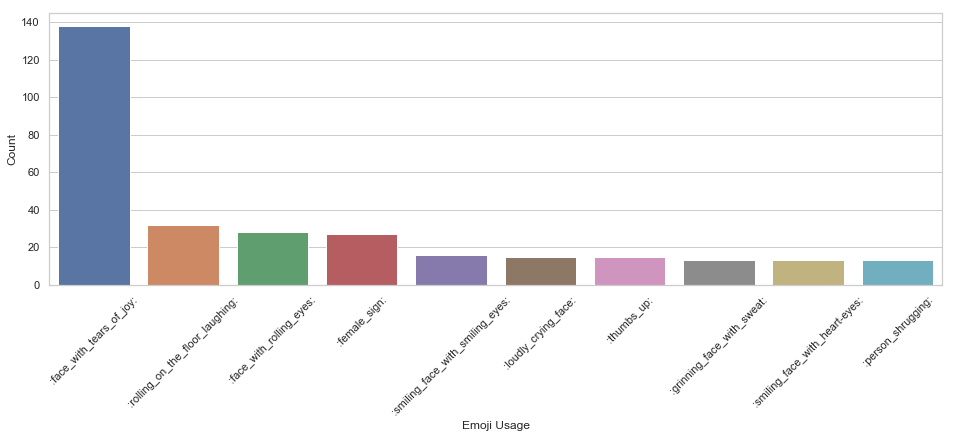

In [171]:
all_emoji = du.get_sorted_emoji_counts(clean_tracking['original'])
all_emoji_text = du.demojize_sorted_emoji_counts(all_emjoi)
du.wordcount_to_bar('Emoji Usage', 'Count', all_emoji_text, rotate=True)

## Hashtag Usage

In [138]:
mention_hash_dict = du.get_hashtag_mention_counts(clean_tracking['original'])
hash_dict = pd.DataFrame

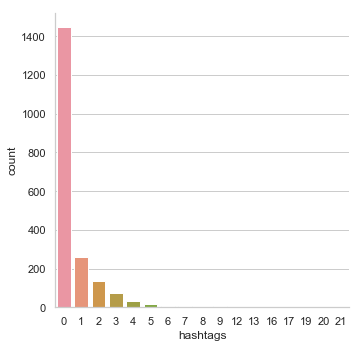

In [139]:
du.counts_to_graph('hashtags', mention_hash_dict['hashtags'])

4


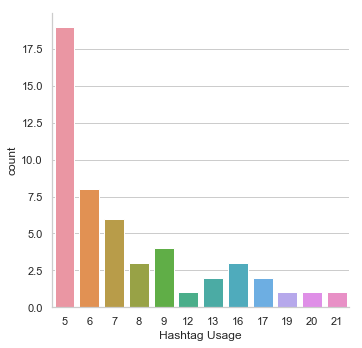

In [252]:
du.counts_to_graph_filter(4, 'Hashtag Usage', mention_hash_dict['hashtags'])

In [219]:
du.get_tweets_based_on_count(21, clean_tracking['original'], mention_hash_dict['hashtags']).iloc[0]

'Be a ProblemSolver !, not creator \n #problemSolving #design #creativity #designThinking #innovation #Win #CEO #HumanCenteredDesign #culture #entrepreneur #Funny #Businessdesign #Creative  #people #love #thankful #entrepreneur #startup #research #cleanEating #bengaluru'

## Hashtags Used

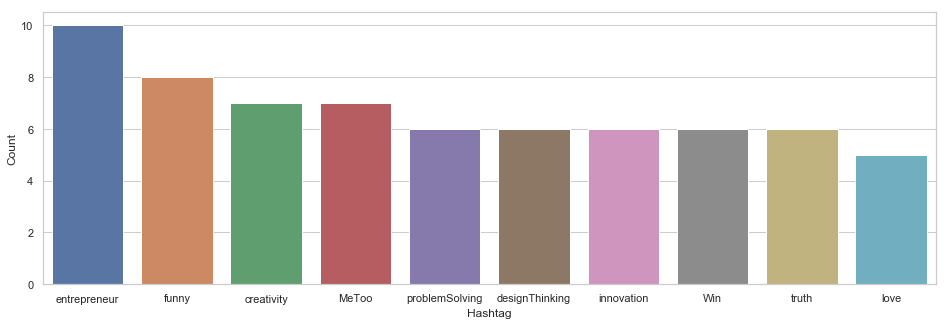

In [169]:
all_hashtags = du.sentences_to_sorted_hashtags(clean_tracking['original'], drop_words)
du.wordcount_to_bar('Hashtag','Count',all_hashtags)

## Mentions Usage

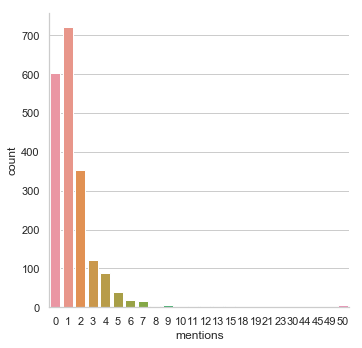

In [165]:
du.counts_to_graph('mentions', mention_hash_dict['mentions'])

4


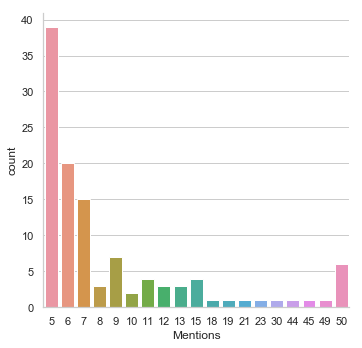

In [253]:
du.counts_to_graph_filter(4, 'Mentions', mention_hash_dict['mentions'])

In [222]:
du.get_tweets_based_on_count(50, clean_tracking['original'], mention_hash_dict['mentions']).iloc[0]

"@Sherry40614670 @rogergumley @IanMCohen @mY_Oh_FaCe @cbowling4512 @Qanon_is_fake @Soapydynasty @misscalliecat @42Gnome @linda_beaumont @HillbillyTruth @cancunbound2022 @TheGraviter @Jasmine15038530 @twitassassin823 @JDW714 @Mandalorian_Ren @44_here @ZyroFoxtrot @jdd2169 @VandersteltTina @JustasPeace @netspionage @SassyMsViolet @kimmyifuplease @IvysGhost @QCritter @kerryjrn @KathleenSorenso @TxConservativeL @jakeboneusa @Randalvini @CaliPhunck @Doophenshmirtz @zazzybritches @KarsinXXX @chibbitycheee @MaryCha20362180 @JaimeJo16349778 @AlexeyHeck @leslie_hubbard @Kieradee @restaurant_mom @Pacoluismonta9a @JohnnyBlkshrt @EricSpahn1 @ethan_cereal @TheChickLivesOn @MissGFYCuffy @AngryandAsian Hey, men and women are equals don't you know? There's absolutely nothing wrong with this. Get #Woke you fascist.\n\n"

In [223]:
du.get_tweets_based_on_count(50, clean_tracking['original'], mention_hash_dict['mentions']).iloc[3]

'@LisaMar91564392 @IproudCanadian @breezing_in @roadcrypto @canadaunited1 @Demslayer13 @Overloard44 @ronmarshaw @NotMyCanada1957 @duanedaniel @SergeHalytsky @nostradamous195 @saskatchewanpov @SusanIverach @MrCanadian69 @cdn_deplorable @AllThySons01 @BeecheyPat @DougHawk @canadian000 @Trans4ormU @elijahfire8 @jfbTRUTH @NewImproved9 @OTJSports @TMrealityczech @4CanadianAction @shoo_choux @wearewhatsdope @annmcc123 @keeks2203 @chevymo @RdR91136574 @bgirl0001 @james_jkellsy @Danbalkwill1 @BrentDgls @RickRed10 @KribbyMortus @DefinitionHolly @VaHoldo @JeremyPhillyFan @CindylouAB @freecoconow @Canadian_Zero @angelo_zeppieri @SZero1337 @RdrHrly @shuqinghou @realDonaldTrump Yeah slush fund of us working hard.'

## Visualizing Word Vectors

In [492]:
for_word2vec = pd.DataFrame()
for_word2vec['text'] = clean_tracking['lemmatized']
for_word2vec['label'] = clean_tracking['label']

In [493]:
corpus = du.build_corpus(for_word2vec)

In [494]:
model = word2vec.Word2Vec(corpus, size=100, window=25, min_count=40, workers=4)

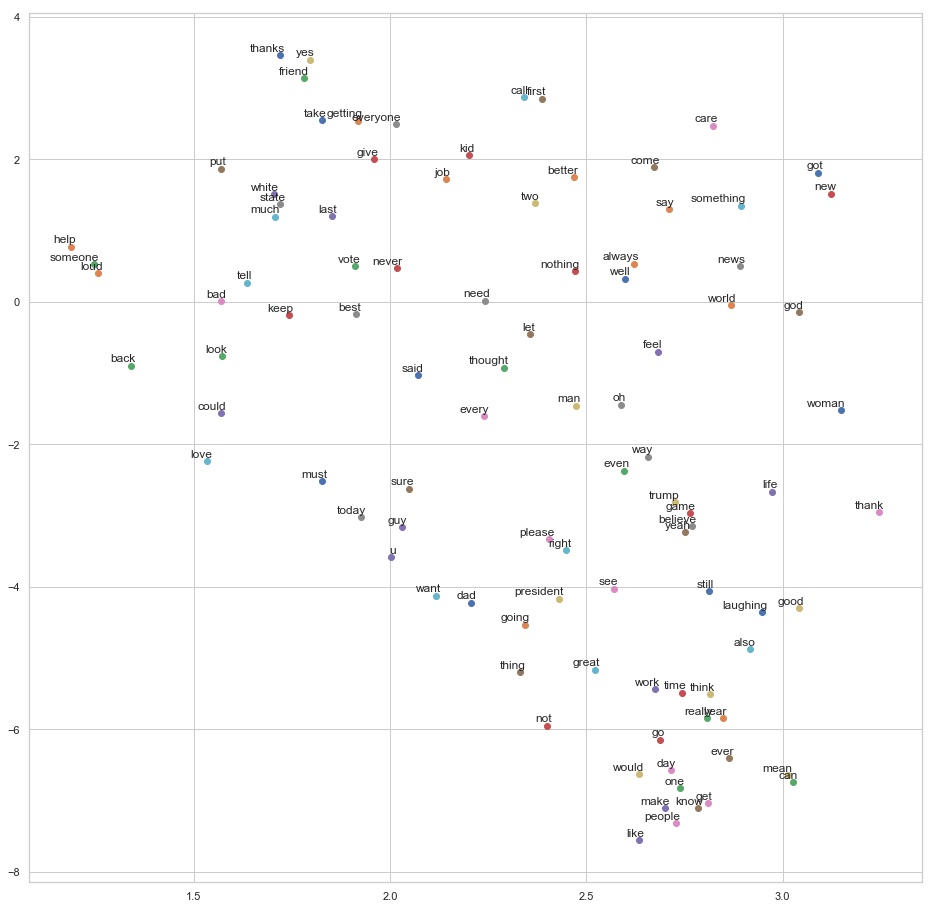

In [495]:
du.tsne_plot(model)

## Topic Modelling

In [496]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
dtm=vect.fit_transform(for_word2vec['text'])
lda=LatentDirichletAllocation(n_components=3)
lda.fit_transform(dtm)

array([[0.941584  , 0.02905506, 0.02936094],
       [0.96279914, 0.01653004, 0.02067082],
       [0.02216153, 0.02142141, 0.95641706],
       ...,
       [0.06946354, 0.86230708, 0.06822938],
       [0.7002596 , 0.16292852, 0.13681188],
       [0.94328716, 0.02878977, 0.02792306]])

In [497]:
lda_dtf=lda.fit_transform(dtm)
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(3), feature_names=features,
sorting=sorting, topics_per_chunk=3, n_words=10)

topic 0       topic 1       topic 2       
--------      --------      --------      
black         people        like          
friend        work          know          
better        mean          people        
like          like          love          
hate          life          time          
probably      vote          good          
think         thought       thing         
baby          make          really        
time          day           make          
way           year          want          




In [498]:
pyLDAvis.enable_notebook()
zit=pyLDAvis.sklearn.prepare(lda,dtm,vect)
pyLDAvis.display(zit)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Sarcasm Analysis

## Word Count

### Non-Sarcastic Word Count

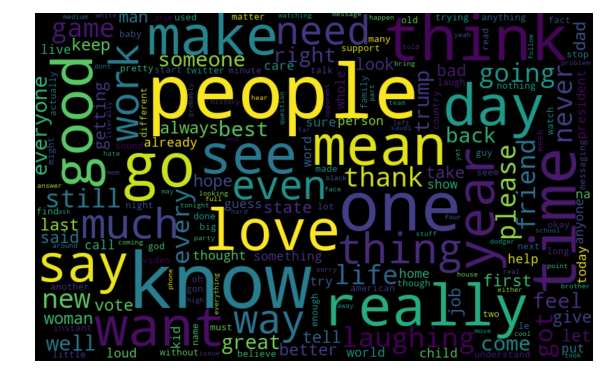

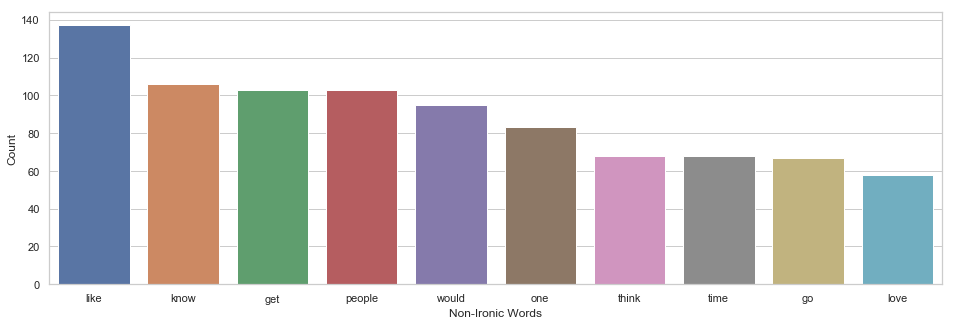

In [149]:
du.sentences_to_wordcloud(analysis['text'][analysis['label']==0], drop_words)
wordcount_nonironic = du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==0], drop_words)
du.wordcount_to_bar('Non-Ironic Words', 'Count', wordcount_nonironic)

### Sarcastic Word Count

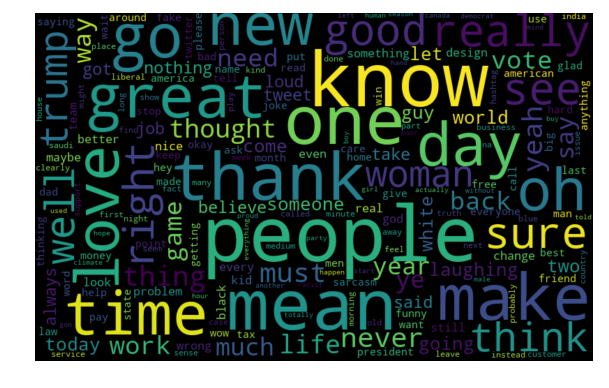

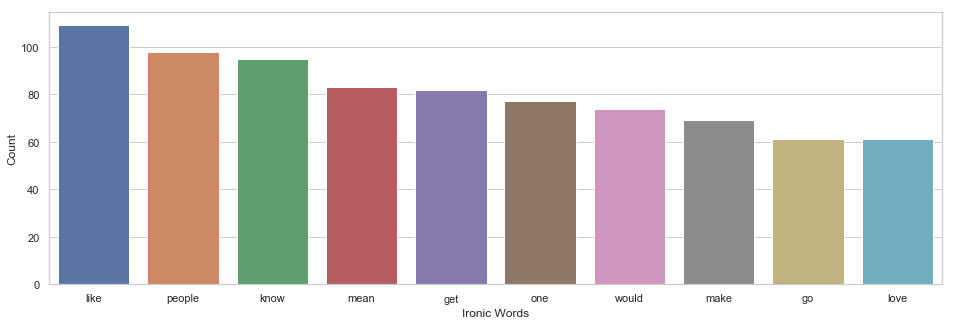

In [148]:
du.sentences_to_wordcloud(analysis['text'][analysis['label']==1], drop_words)
wordcount_ironic = du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==1], drop_words)
du.wordcount_to_bar('Ironic Words', 'Count', wordcount_ironic)

### Unique Non-Sarcastic Words

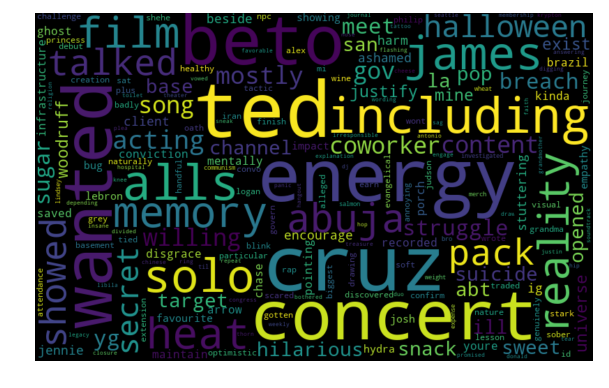

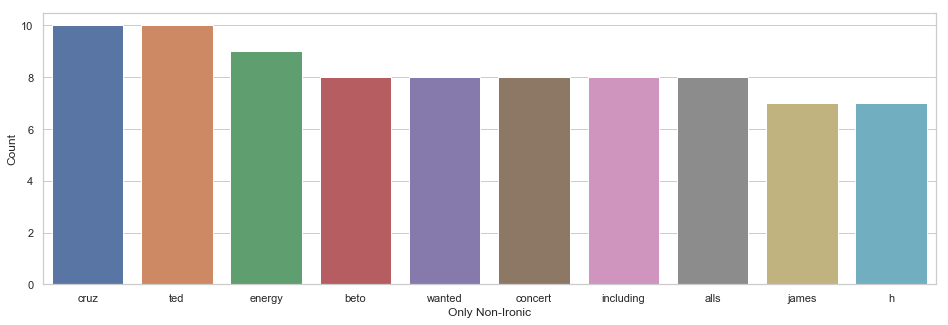

In [152]:
nonironic_words = du.sentences_to_words(analysis['text'][analysis['label']==0]).split()
du.sentences_to_wordcloud(analysis['text'][analysis['label']==0], drop_words+ironic_words) 
wordcount_only_nonironic = du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==0], drop_words+ironic_words) 
du.wordcount_to_bar('Only Non-Ironic', 'Count', wordcount_only_nonironic)

### Unique Sarcastic Words

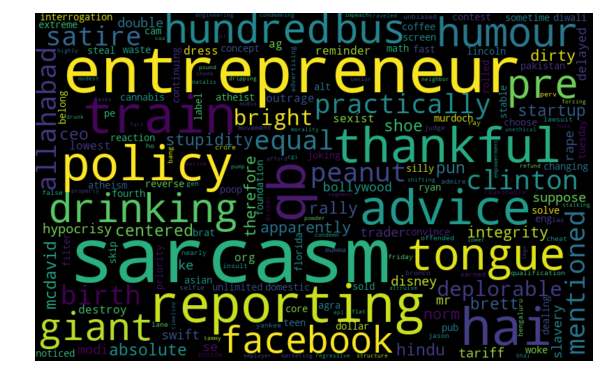

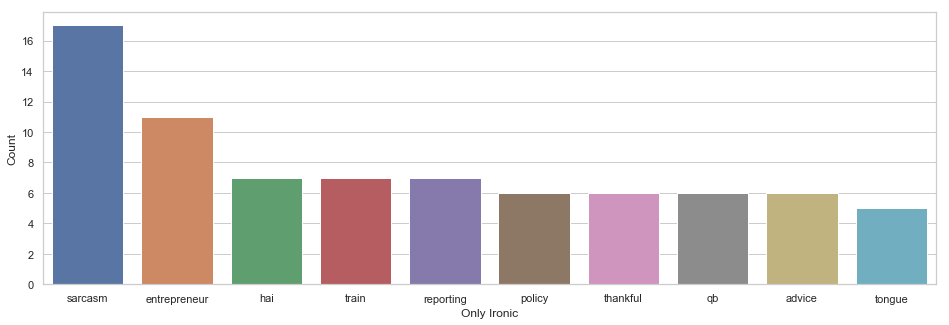

In [154]:
ironic_words = du.sentences_to_words(analysis['text'][analysis['label']==1]).split()
du.sentences_to_wordcloud(analysis['text'][analysis['label']==1], drop_words+nonironic_words) 
wordcount_only_ironic=du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==1], drop_words+nonironic_words)[:10] 
du.wordcount_to_bar('Only Ironic', 'Count', wordcount_only_ironic)

## Hashtags

### Non-Ironic Hashtags

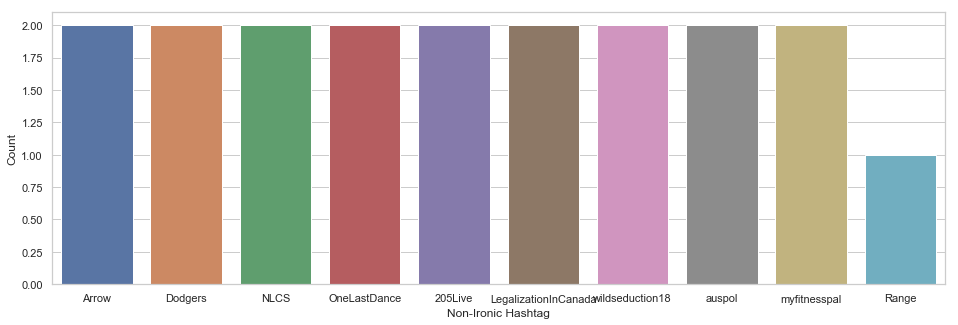

In [254]:
nonironic_hashtags = du.sentences_to_sorted_hashtags(analysis['orig'][analysis['label']==0], drop_words)
du.wordcount_to_bar('Non-Ironic Hashtag','Count',nonironic_hashtags)

### Ironic Hashtags

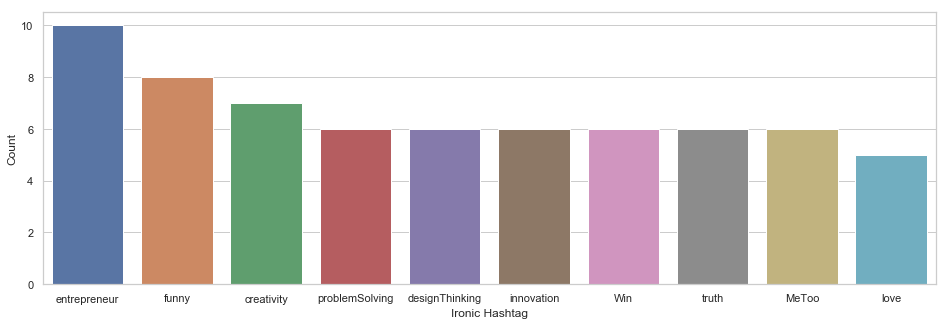

In [143]:
ironic_hashtags = du.sentences_to_sorted_hashtags(analysis['orig'][analysis['label']==1], drop_words)
du.wordcount_to_bar('Ironic Hashtag','Count',ironic_hashtags)

## Emoji

### Nonsarcastic Emoji

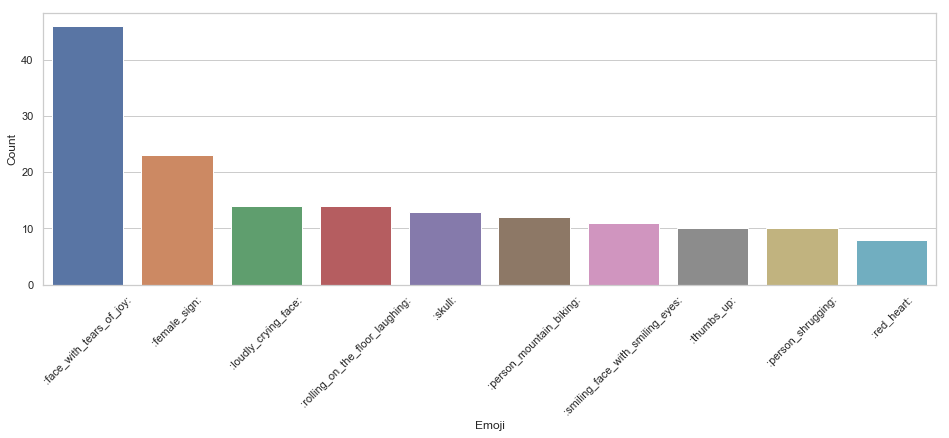

In [380]:
nonsarc_emjoi = du.get_sorted_emoji_counts(clean_tracking[clean_tracking['label']==0]['original'])
nonsarc_emjoi_text = du.demojize_sorted_emoji_counts(nonsarc_emjoi)
du.wordcount_to_bar('Emoji', 'Count', nonsarc_emjoi_text, rotate=True)

### Sarcastic Emoji

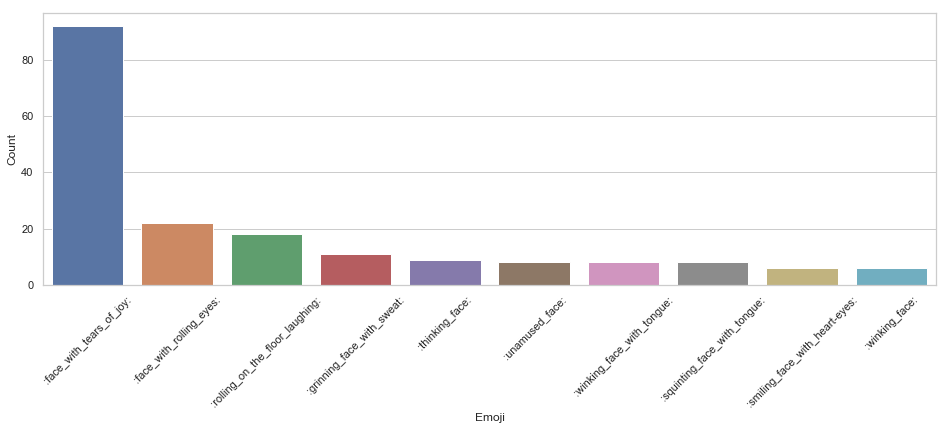

In [381]:
sarc_emjoi = du.get_sorted_emoji_counts(clean_tracking[clean_tracking['label']==1]['original'])
sarc_emjoi_text = du.demojize_sorted_emoji_counts(sarc_emjoi)
du.wordcount_to_bar('Emoji', 'Count', sarc_emjoi_text, rotate=True)

### Elongated and Repeated Words

In [312]:
# change the text to label
rep_elong = du.get_elongated_repeated_from_tags(clean_tracking['text_processor'])

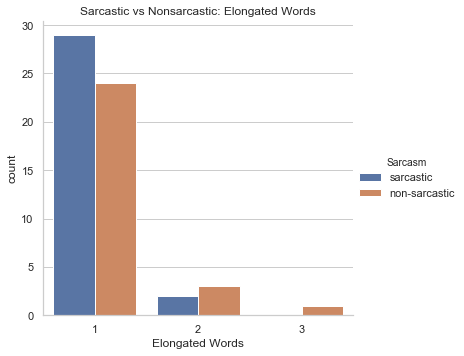

In [357]:
sarc_vs_non_graph_limit('Elongated Words', 
                        rep_elong['elongated'], 
                        clean_tracking['label'],0)

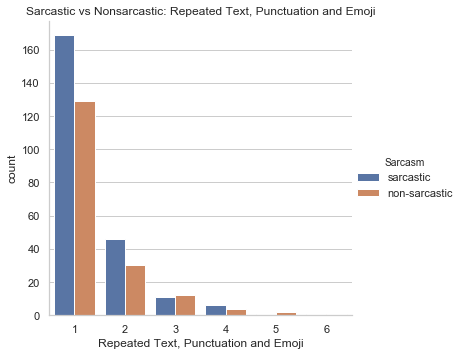

In [407]:
sarc_vs_non_graph_limit('Repeated Text, Punctuation and Emoji', 
                        rep_elong['repeated'], 
                        clean_tracking['label'],
                        0)

## Hashtag Usage

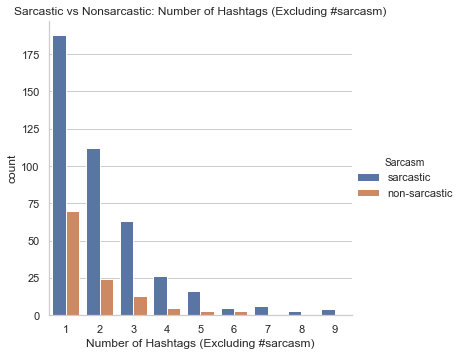

In [408]:
sarc_vs_non_graph_limit('Number of Hashtags (Excluding #sarcasm)', 
                        mention_hash_dict['hashtags'], 
                        clean_tracking['label'],
                        0,12)

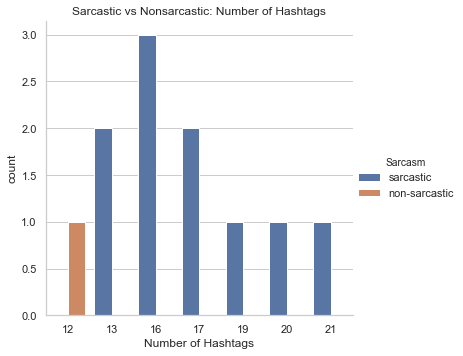

In [375]:
sarc_vs_non_graph_limit('Number of Hashtags', 
                        mention_hash_dict['hashtags'], 
                        clean_tracking['label'],
                        9)

## Mentions 

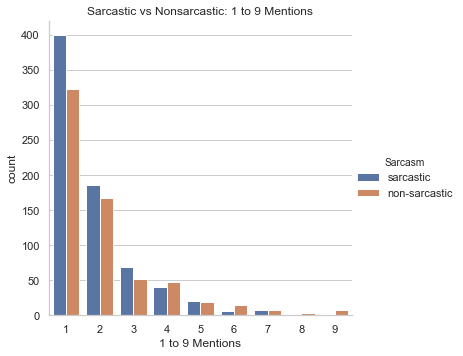

In [409]:
sarc_vs_non_graph_limit('1 to 9 Mentions', 
                        mention_hash_dict['mentions'], 
                        clean_tracking['label'],
                        0,10)

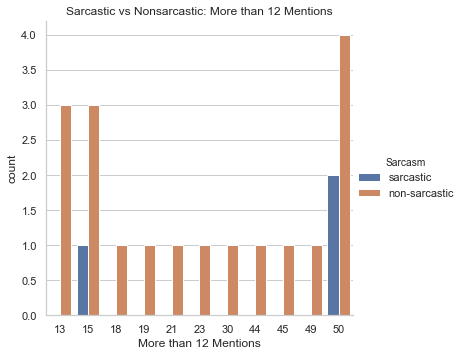

In [410]:
sarc_vs_non_graph_limit('More than 12 Mentions', 
                        mention_hash_dict['mentions'], 
                        clean_tracking['label'],
                        12)

## Sentiment

### General Sentiment 

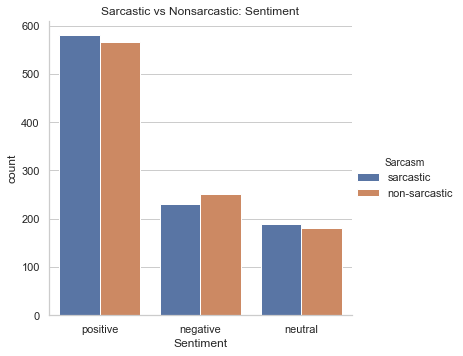

In [444]:
sentiment_data_list = du.get_sentiment_textblob(clean_tracking['contractions_expanded'])
du.sarc_vs_non_graph('Sentiment', sentiment_data_list, clean_tracking['label'])

### Sentiment Intensity

In [446]:
sentiment_feats = pd.DataFrame()
sentiment_feats = du.generate_sentiment_feats(clean_tracking['contractions_expanded'])
sentiment_feats.head()

,t_neg,t_pos,t_neu,t_cmpd,vp_neg,vp_pos,vp_neu,vp_cmpd,n_neg,n_pos,n_neu,n_cmpd
0,0.000,0.186,0.814,0.7251,0.00,1.000,6.000,0.3400,0.0,0.000,3.000,0.0000
1,0.045,0.070,0.884,0.0644,1.00,1.000,5.000,-0.4651,0.0,1.000,13.000,0.5719
2,0.067,0.199,0.734,0.7184,0.00,2.000,5.000,0.7837,0.0,0.643,7.357,0.2023
3,0.136,0.098,0.766,-0.0931,1.73,0.000,3.270,-0.6286,0.0,0.000,5.000,0.0000
4,0.162,0.087,0.751,-0.6825,0.00,1.655,6.345,0.2521,0.0,0.000,4.000,0.0000


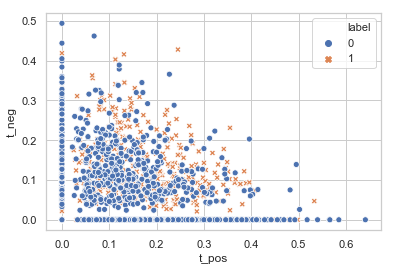

In [447]:
ax = sns.scatterplot(x="t_pos", y="t_neg",hue="label", style="label", data=scatter)

In [448]:
graphs = [['t_cmpd', 'Full Tweet Compound Sentiment'],
         ['t_pos', 'Full Tweet Positive Sentiment'],
         ['t_neg','Full Tweet Negative Sentiment'],
         ['vp_cmpd','Verb Phrase Compound Sentiment'],
         ['vp_pos','Verb Phrase Positive Sentiment'],
         ['vp_neg','Verb Phrase Negative Sentiment'],
         ['n_cmpd','Noun Phrase Compound Sentiment'],
         ['n_pos','Noun Phrase Positive Sentiment'],
         ['n_neg','Noun Phrase Negative Sentiment']]

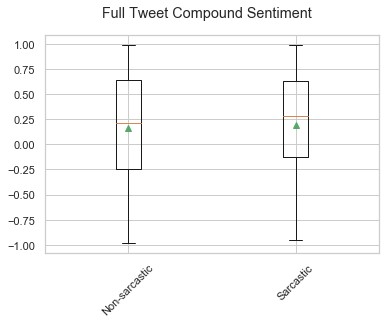

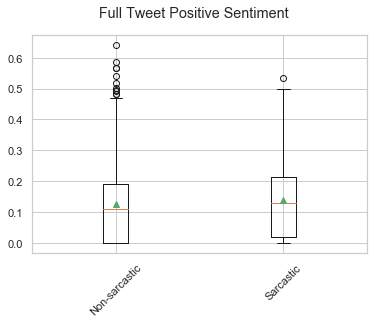

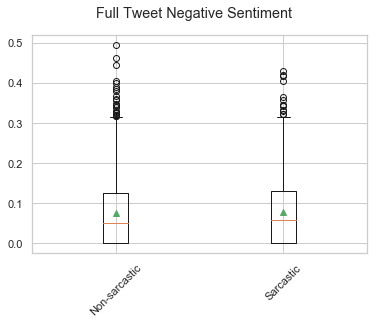

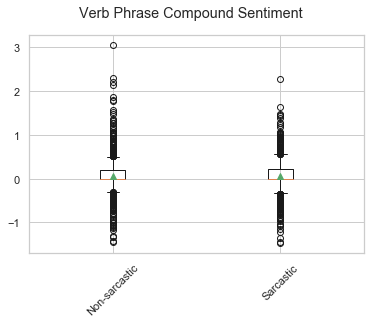

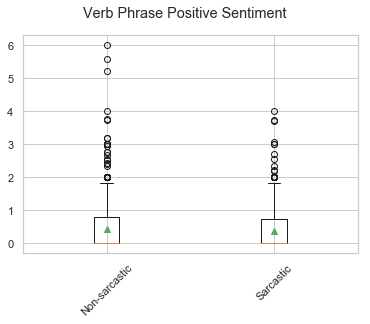

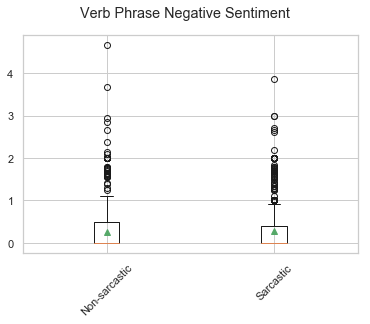

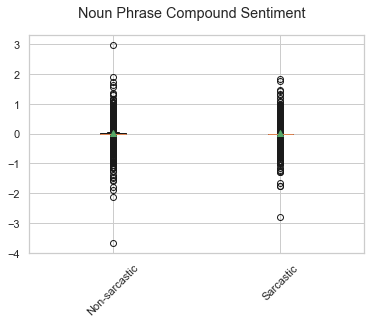

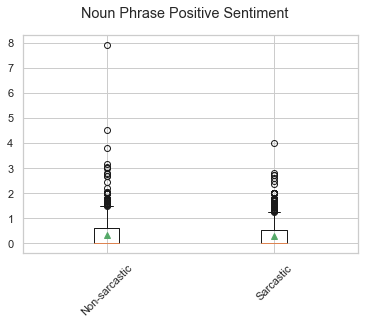

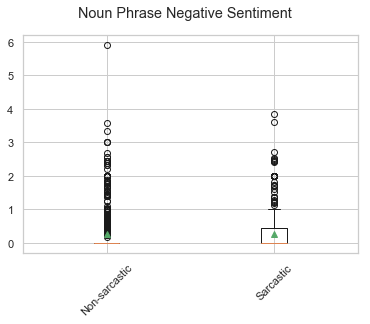

In [449]:
for graph in graphs:
    du.sentiment_intensity_box_compare(graph[1],graph[0],sentiment_feats, clean_tracking['label'])

### Sentiment Contradictions

In [462]:
#identify contradictions in sentiment
contradiction = []
for index, r in sentiment_feats.iterrows():
    if r['t_cmpd'] > 0 and r['vp_cmpd'] < 0:
        contradiction.append(1)
    elif r['t_cmpd'] < 0 and r['vp_cmpd'] > 0:
        contradiction.append(1)
    elif r['t_cmpd'] > 0 and r['vp_cmpd'] < 0:
        contradiction.append(1)
    elif r['t_cmpd'] < 0 and r['n_cmpd'] > 0:
        contradiction.append(1)
    elif r['t_cmpd'] > 0 and r['n_cmpd'] < 0:
        contradiction.append(1)
    else:
        contradiction.append(0)



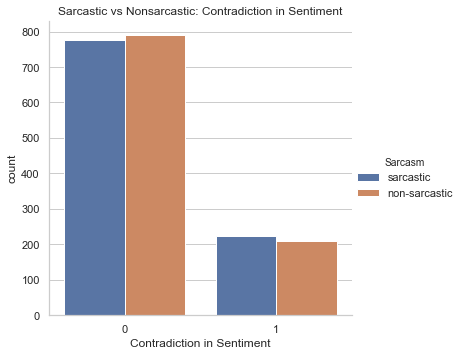

In [460]:
du.sarc_vs_non_graph('Contradiction in Sentiment', contradiction, clean_tracking['label'])

## Bag of Emoji

In [467]:
bag_of_emoji_feats = pd.DataFrame()
bag_of_emoji_feats = du.get_bag_of_emoji(clean_tracking['original'])

In [468]:
bag_of_emoji_feats.head()

,:face_with_tears_of_joy:,:rolling_on_the_floor_laughing:,:face_with_rolling_eyes:,:female_sign:,:smiling_face_with_smiling_eyes:,:loudly_crying_face:,:thumbs_up:,:grinning_face_with_sweat:,:smiling_face_with_heart-eyes:,:person_shrugging:,:skull:,:thinking_face:,:person_mountain_biking:,:folded_hands:,:unamused_face:,:squinting_face_with_tongue:,:winking_face:
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Repeated and Elongated 

In [514]:
# change the text to label
rep_elong_feats = pd.DataFrame()
rep_elong_feats['repeated'] = rep_elong['repeated']
rep_elong_feats['elongated'] = rep_elong['elongated']
rep_elong_feats.head()

,repeated,elongated
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0


## Mention and Hashtag

In [515]:
ment_tag_feats = pd.DataFrame()
ment_tag_feats['mentions'] = mention_hash_dict['mentions']
ment_tag_feats['hashtags'] = mention_hash_dict['hashtags']
ment_tag_feats.head()

,mentions,hashtags
0,1,0
1,4,0
2,0,2
3,7,1
4,1,1


## Sentiment

In [508]:
sentiment_cont_feats = pd.DataFrame()
sentiment_cont_feats = sentiment_feats.drop('label',axis=1)
sentiment_cont_feats['contradiction'] = contradiction
sentiment_cont_feats.head()

,t_neg,t_pos,t_neu,t_cmpd,vp_neg,vp_pos,vp_neu,vp_cmpd,n_neg,n_pos,n_neu,n_cmpd,contradiction
0,0.000,0.186,0.814,0.7251,0.00,1.000,6.000,0.3400,0.0,0.000,3.000,0.0000,0
1,0.045,0.070,0.884,0.0644,1.00,1.000,5.000,-0.4651,0.0,1.000,13.000,0.5719,1
2,0.067,0.199,0.734,0.7184,0.00,2.000,5.000,0.7837,0.0,0.643,7.357,0.2023,0
3,0.136,0.098,0.766,-0.0931,1.73,0.000,3.270,-0.6286,0.0,0.000,5.000,0.0000,0
4,0.162,0.087,0.751,-0.6825,0.00,1.655,6.345,0.2521,0.0,0.000,4.000,0.0000,1


Model:		SVM Word TF-IDF
CV Mean:	0.65
CV Range:	0.06499999999999995
Train Time:	0.13740897178649902
CV Scores: 
[0.635  0.6775 0.6125 0.665  0.66  ]


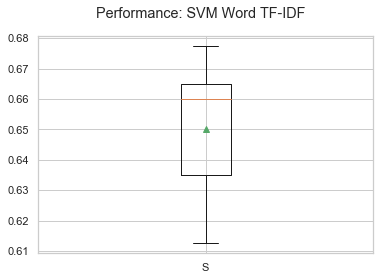

In [513]:
#svm_count_vectors = Model('SVM Count Vectors',xtrain_count,y_train,svm.SVC())
svm_tfidf_ngram = du.Model('SVM Word TF-IDF',combo,y,svm.LinearSVC())
svm_tfidf_ngram.performance()

## TF-IDF Features

In [469]:
feature_creation = pd.DataFrame()
feature_creation['text'] = clean_tracking['lemmatized']
feature_creation['label'] = clean_tracking['label']
y=clean_tracking['label']

In [470]:
# isolate data for tf-idf feature creation
x_train_tfidf = clean_tracking['lemmatized']

### Word Level

In [471]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=500000)
tfidf_vect.fit(x_train_tfidf)
xtrain_tfidf =  tfidf_vect.transform(x_train_tfidf)

### ngram Level  

In [472]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(x_train_tfidf)
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(x_train_tfidf)

### Character Level 

In [473]:
# character level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(x_train_tfidf)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train_tfidf)

# Models

In [475]:
y=clean_tracking['label']

## Naive Bayes

### Evaluate Non-TF-IDF Features

In [519]:
nontfidf_feats = pd.DataFrame()
nontfidf_feats = pd.concat([sentiment_cont_feats,
                   ment_tag_feats,
                   rep_elong_feats,
                   bag_of_emoji_feats], axis=1)

In [523]:
#nb_sentiment = du.Model('Sentiment',sentiment_cont_feats,y,naive_bayes.MultinomialNB())
nb_emoji = du.Model('Bag of Emoji',bag_of_emoji_feats,y,naive_bayes.MultinomialNB())
nb_ment_tag = du.Model('Mentions Hashtags',ment_tag_feats,y,naive_bayes.MultinomialNB())
nb_rep_elong = du.Model('Repeated Elongated',rep_elong_feats,y,naive_bayes.MultinomialNB())
#nb_allnontfidf = du.Model('All Non-TF-IDF',nontfidf_feats,y,naive_bayes.MultinomialNB())

,Name,CV Mean,CV Range,Time
0,Bag of Emoji,0.5140,0.0200,0.002897
1,Mentions Hashtags,0.6525,0.0400,0.000758
2,Repeated Elongated,0.5180,0.0425,0.000867


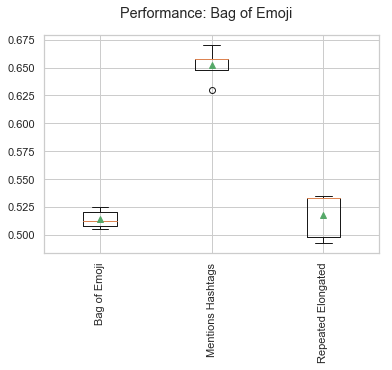

In [525]:
nb_emoji.fullCompareList([nb_ment_tag,nb_rep_elong])

### Evaluate TF-IDF Features

In [ ]:
nb_tfidf_word = du.Model('NB Word TF-IDF',xtrain_tfidf,y,naive_bayes.MultinomialNB())
nb_tfidf_ngram = du.Model('NB N-Gram',xtrain_tfidf_ngram,y,naive_bayes.MultinomialNB())
nb_ftidf_ngram_chars = du.Model('NB Char TF-IDF',xtrain_tfidf_ngram_chars,y,naive_bayes.MultinomialNB())

,Name,CV Mean,CV Range,Time
0,NB Word TF-IDF,0.6115,0.0575,0.056414
1,NB N-Gram,0.5530,0.0450,0.001118
2,NB Char TF-IDF,0.5825,0.0450,0.004889


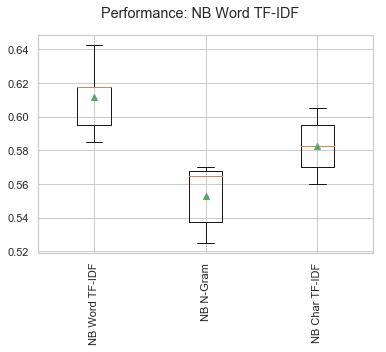

In [479]:
nb_tfidf_word.fullCompareList([nb_tfidf_ngram,nb_ftidf_ngram_chars])

## Linear Classifier

In [482]:
#lc_count_vectors = Model('LC Count Vectors',xtrain_count,y_train,linear_model.LogisticRegression())
lc_tfidf_word = du.Model('LC Word TF-IDF',xtrain_tfidf,y,linear_model.LogisticRegression())
lc_tfidf_ngram = du.Model('LC N-Gram',xtrain_tfidf_ngram,y,linear_model.LogisticRegression())
lc_ftidf_ngram_chars = du.Model('LC Char TF-IDF',xtrain_tfidf_ngram_chars,y,linear_model.LogisticRegression())

,Name,CV Mean,CV Range,Time
0,LC Word TF-IDF,0.6145,0.0525,0.009189
1,LC N-Gram,0.5540,0.0550,0.004438
2,LC Char TF-IDF,0.5725,0.0300,0.032410


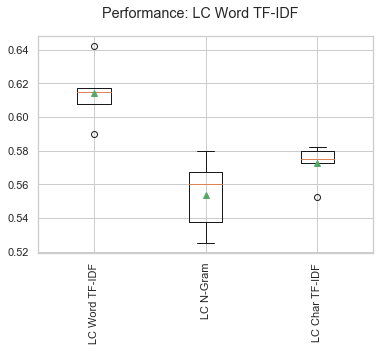

In [483]:
lc_tfidf_word.fullCompareList([lc_tfidf_ngram,lc_ftidf_ngram_chars])

## SVM

Model:		SVM Word TF-IDF
CV Mean:	0.6160000000000001
CV Range:	0.050000000000000044
Train Time:	0.012430906295776367
CV Scores: 
[0.595  0.6075 0.615  0.645  0.6175]


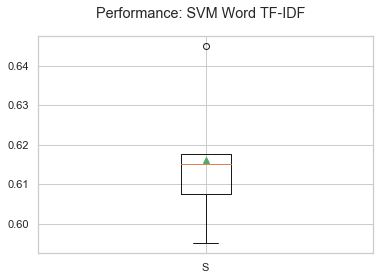

In [529]:
#svm_count_vectors = Model('SVM Count Vectors',xtrain_count,y_train,svm.SVC())
svm_tfidf_word = du.Model('SVM Word TF-IDF',xtrain_tfidf,y,svm.LinearSVC())
svm_tfidf_word.performance()

In [526]:
#svm_tfidf_ngram = du.Model('SVM Word TF-IDF',xtrain_tfidf,y,svm.LinearSVC())

svm_sentiment = du.Model('Sentiment',sentiment_cont_feats,y,svm.LinearSVC())
svm_emoji = du.Model('Bag of Emoji',bag_of_emoji_feats,y,svm.LinearSVC())
svm_ment_tag = du.Model('Mentions Hashtags',ment_tag_feats,y,svm.LinearSVC())
svm_rep_elong = du.Model('Repeated Elongated',rep_elong_feats,y,svm.LinearSVC())
svm_allnontfidf = du.Model('All Non-TF-IDF',nontfidf_feats,y,svm.LinearSVC())

,Name,CV Mean,CV Range,Time
0,Sentiment,0.5530,0.065,0.131573
1,Bag of Emoji,0.5155,0.020,0.063403
2,Mentions Hashtags,0.6570,0.040,0.067578
3,Repeated Elongated,0.5245,0.035,0.048137
4,All Non-TF-IDF,0.6525,0.065,0.151969
5,SVM Word TF-IDF,0.6160,0.050,0.012431


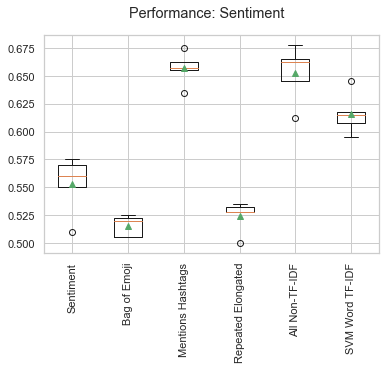

In [530]:
svm_sentiment.fullCompareList([svm_emoji,svm_ment_tag,svm_rep_elong,svm_allnontfidf,svm_tfidf_word])

## Extreme Gradient Boosting

In [486]:
xgb_tfidf_word = du.Model('XGB Word TF-IDF',xtrain_tfidf,y,xgboost.XGBClassifier())
xgb_tfidf_ngram = du.Model('XGB N-Gram',xtrain_tfidf_ngram,y,xgboost.XGBClassifier())
xgb_ftidf_ngram_chars = du.Model('XGB Char TF-IDF',xtrain_tfidf_ngram_chars,y,xgboost.XGBClassifier())

,Name,CV Mean,CV Range,Time
0,XGB Word TF-IDF,0.5840,0.0550,0.592245
1,XGB N-Gram,0.5075,0.0225,0.182935
2,XGB Char TF-IDF,0.5650,0.0375,4.070781


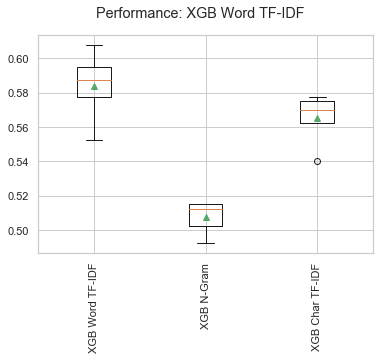

In [487]:
xgb_tfidf_word.fullCompareList([xgb_tfidf_ngram, xgb_ftidf_ngram_chars])

## Neural Network

In [531]:
from sklearn.model_selection import train_test_split


In [532]:
for_nn = pd.DataFrame()
for_nn['text'] = analysis['text']
for_nn['label'] = analysis['label']

In [533]:
train, test = train_test_split(for_nn, test_size=0.5)

train_x = train['text'] 
train_y = train['label']
test_x = test['text'] 
test_y = test['label']

In [534]:
train_x.head()

458               nevertheless clearly voted two year ago
1884    stand real swing miss sometimes weak time inst...
896     commoner done better task neha jealous soul sp...
1843    dear know job respect hustle love nigeria care...
988                        swoon self proclaimed feminist
Name: text, dtype: object

In [535]:
from keras.preprocessing import text, sequence

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(train_x)
word_index = token.word_index

In [536]:
from __future__ import division, print_function, absolute_import
from tensorflow import reset_default_graph
reset_default_graph()

import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb

# Data preprocessing
# Sequence padding
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=100)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen=100)

# Converting labels to binary vectors
train_cat_y = to_categorical(train_y, nb_classes=2)
test_cat_y = to_categorical(test_y, nb_classes=2)

# Network building
net = tflearn.input_data([None, 100])
net = tflearn.embedding(net, input_dim=10000, output_dim=128)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')



Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [537]:
# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(train_seq_x, train_cat_y, validation_set=(test_seq_x, test_cat_y), show_metric=True,
          batch_size=32)

Training Step: 319  | total loss: 0.00221 | time: 6.956s
| Adam | epoch: 010 | loss: 0.00221 - acc: 0.9999 -- iter: 0992/1000
Training Step: 320  | total loss: 0.00215 | time: 8.812s
| Adam | epoch: 010 | loss: 0.00215 - acc: 0.9999 | val_loss: 1.76934 - val_acc: 0.5780 -- iter: 1000/1000
--


# CNN

In [538]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, test_y)

In [539]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

In [540]:
# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [541]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model



In [542]:
# Data preprocessing
# Sequence padding
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen=70)


In [543]:
classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings " + str(accuracy))

Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6946
CNN, Word Embeddings 0.495
